In [1]:
import math
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="timm")

import matplotlib.pyplot as plt
import numpy as np
import torch

from experiment_config import config
from models.model_hiera import Hiera3D

current_dir = Path(os.getcwd())
workspace_root = current_dir.parent

# the folder to save plots
figures_dir = Path(f"/{workspace_root}/figures")
figures_dir.mkdir(exist_ok=True)

Local pretrained model found at //workspace/hiera-luna25-finetuning/resources/mae_hiera_large_16x224.pth. Loading directly...
Plot saved to //workspace/figures/1c_pos_embed_spatial_16x224.png


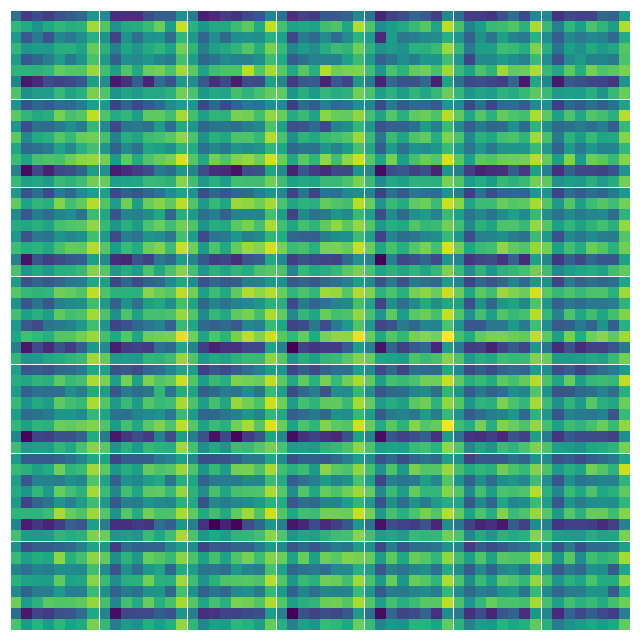

Local pretrained model found at //workspace/hiera-luna25-finetuning/resources/mae_hiera_large_16x224.pth. Loading directly...
Plot saved to //workspace/figures/1c_pos_embed_spatial_16x64_bugged.png


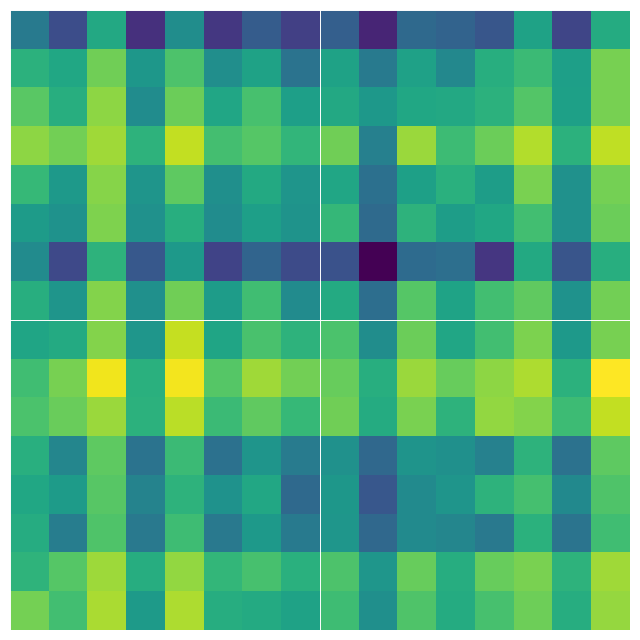

In [2]:
def plot_one_channel_pos_embed_spatial(pos_embed_spatial, plot_name, channel_idx=0):
    """
    Plot one channel of the spatial position embedding in Hiera.
    """
    n, seq_length, hidden_dim = pos_embed_spatial.shape
    assert n == 1
    seq_length_1d = int(math.sqrt(seq_length))
    assert seq_length_1d * seq_length_1d == seq_length
    pos_embed_spatial = pos_embed_spatial.reshape(1, seq_length_1d, seq_length_1d, hidden_dim)
    pos_embed_spatial_1c = pos_embed_spatial[0, :, :, channel_idx].detach().numpy()

    plt.figure(figsize=(8, 8))
    plt.matshow(pos_embed_spatial_1c, cmap="viridis", fignum=1)
    plt.xticks([])
    plt.yticks([])
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)

    tick_positions = np.arange(0, seq_length_1d + 1, 8)
    ax.set_xticks(tick_positions - 0.5, minor=False)
    ax.set_yticks(tick_positions - 0.5, minor=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which="major", color="white", linestyle="-", linewidth=0.7)
    ax.tick_params(which="major", length=0)

    save_path = figures_dir / plot_name
    plt.savefig(save_path, dpi=300, bbox_inches="tight", pad_inches=0)
    print(f"Plot saved to {save_path}")
    plt.show()

def plot_pos_embed(image_size, image_depth, plot_label=None, kind="pretrained", channel_idx=0):
    plot_name = f"1c_pos_embed_spatial_{image_depth}x{image_size}.png"
    if plot_label is not None:
        plot_name = f"1c_pos_embed_spatial_{image_depth}x{image_size}_{plot_label}.png"
    model = Hiera3D(image_size=image_size, image_depth=image_depth, kind=kind)
    pos_embed_spatial = model.hiera.pos_embed_spatial
    plot_one_channel_pos_embed_spatial(pos_embed_spatial, plot_name, channel_idx)

# use naive interpolation (bugged, misaligned)
config.HACK["ENABLE"] = False
plot_pos_embed(image_size=224, image_depth=16)
plot_pos_embed(image_size=64, image_depth=16, plot_label="bugged")

Local pretrained model found at //workspace/hiera-luna25-finetuning/resources/mae_hiera_large_16x224.pth. Loading directly...
Plot saved to //workspace/figures/1c_pos_embed_spatial_16x64_bug-fixed.png


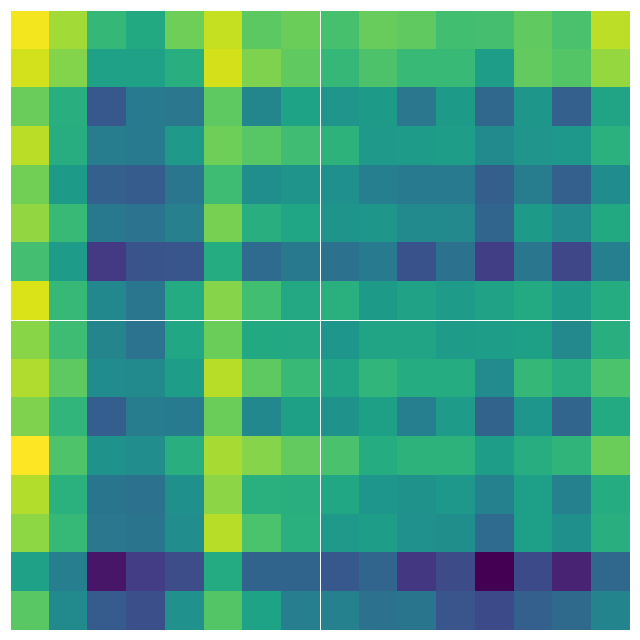

Plot saved to //workspace/figures/1c_pos_embed.png


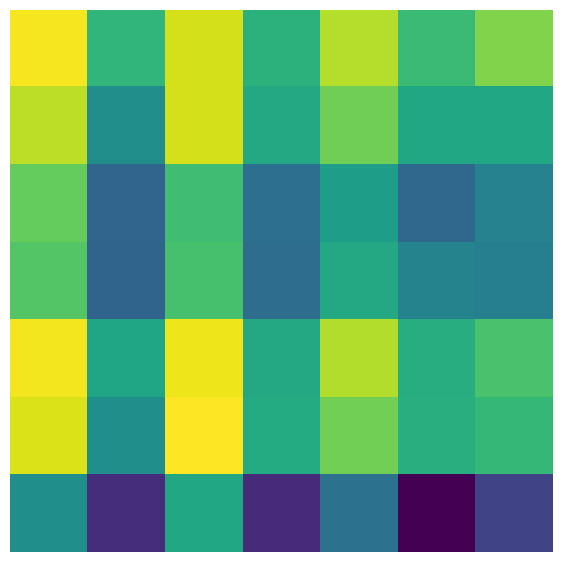

Plot saved to //workspace/figures/1c_pos_embed_window.png


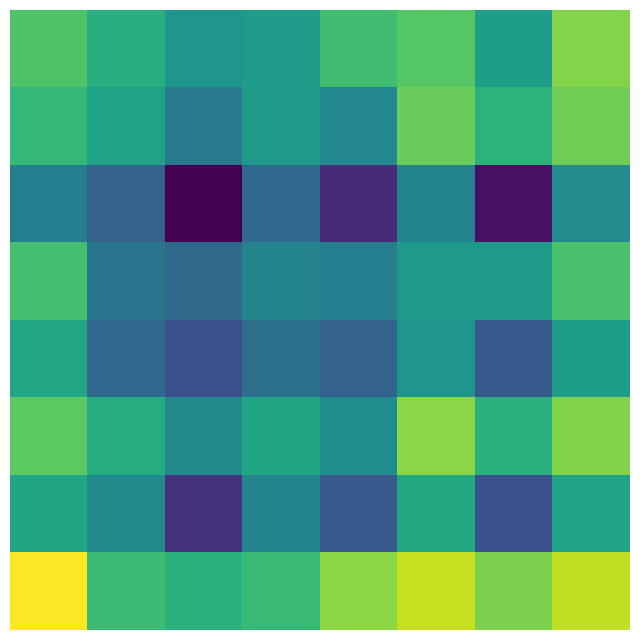

Plot saved to //workspace/figures/1c_pos_embed_interpolated.png


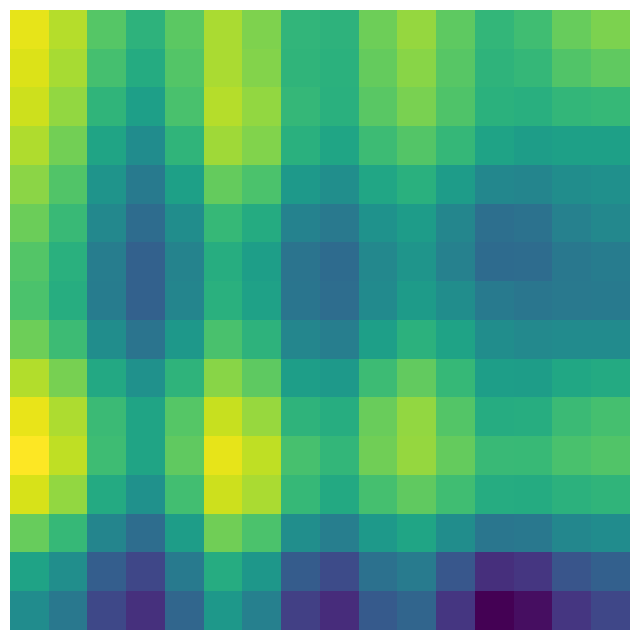

Plot saved to //workspace/figures/1c_pos_embed_window_tiled.png


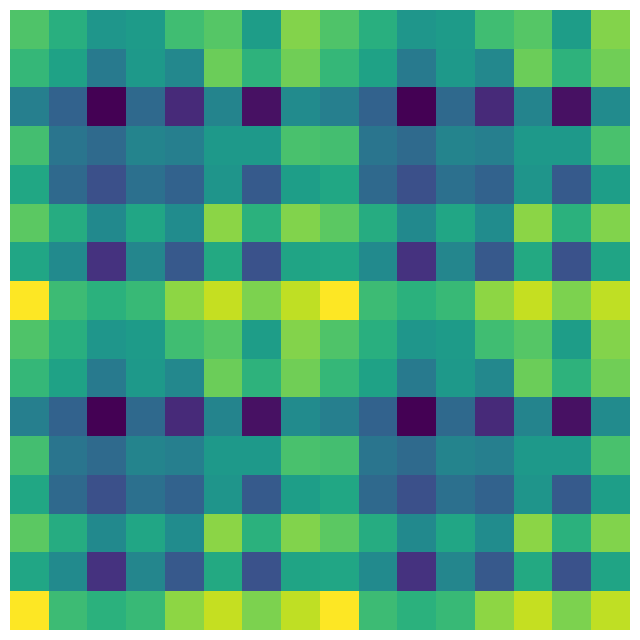

In [3]:
def plot_one_channel_pos_embed_new(pos_embed, dim, plot_name, channel_idx=0):
    """
    Plot one channel of the position embedding (+/- interpolation) or the window position embedding (+/- tiling) in SAM2.1.
    """
    n, _, dim1, dim2 = pos_embed.shape
    assert n == 1
    assert dim1 == dim2 and dim1 == dim
    pos_embed_1c = pos_embed[0, channel_idx, :, :].detach().numpy()

    plot_size = min(dim, 8)
    plt.figure(figsize=(plot_size, plot_size))
    plt.matshow(pos_embed_1c, cmap="viridis", fignum=1)
    plt.xticks([])
    plt.yticks([])
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)
    save_path = figures_dir / plot_name
    plt.savefig(save_path, dpi=300, bbox_inches="tight", pad_inches=0)
    print(f"Plot saved to {save_path}")
    plt.show()

# use new interpolation (bug-fixed, aligned)
config.HACK["ENABLE"] = True
plot_pos_embed(image_size=64, image_depth=16, plot_label="bug-fixed")

pos_embed = torch.from_numpy(np.load(config.HACK["NPY_DIR_POS_EMBED"]))
pos_embed_window = torch.from_numpy(np.load(config.HACK["NPY_DIR_POS_EMBED_WINDOW"]))
plot_one_channel_pos_embed_new(pos_embed, 7, "1c_pos_embed.png")
plot_one_channel_pos_embed_new(pos_embed_window, 8, "1c_pos_embed_window.png")

pos_embed_interpolated = torch.nn.functional.interpolate(pos_embed, size=(64 // 4, 64 // 4), mode="bicubic")
pos_embed_window_tiled = pos_embed_window.tile([x // y for x, y in zip(pos_embed_interpolated.shape, pos_embed_window.shape)])
plot_one_channel_pos_embed_new(pos_embed_interpolated, 64 // 4, "1c_pos_embed_interpolated.png")
plot_one_channel_pos_embed_new(pos_embed_window_tiled, 64 // 4, "1c_pos_embed_window_tiled.png")